In [6]:
#Load the required libraries
import os
import dotenv
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
from matplotlib import ticker

In [7]:
# Load environment variables
project_dir = os.path.join(os.path.abspath(''), os.pardir)
dotenv_path = os.path.join(project_dir, '.env')

dotenv.load_dotenv(dotenv_path)

True

In [8]:
# Load data, it is in CSV format
# assign Na if 0 is detected
df_with_zeros = pd.read_csv(os.getenv('DATA_PATH'))
df = pd.read_csv(os.getenv('DATA_PATH'), keep_default_na = True, na_values = [0, '0'])

# Initial Data Inspection

In [9]:
# Basic information
print("-------ZEROS INCLUDED-------\n")
df_with_zeros.info()
print("\n")
print("-------ZEROS EXCLUDED-------\n")
df.info()

-------ZEROS INCLUDED-------

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78803 entries, 0 to 78802
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   client_id        78803 non-null  int64  
 1   post_id          78803 non-null  object 
 2   Message Text     78803 non-null  object 
 3   Date             78803 non-null  object 
 4   Impressions      78803 non-null  float64
 5   Likes            78803 non-null  float64
 6   Shares           78803 non-null  float64
 7   Comments         78803 non-null  float64
 8   Published Date   78803 non-null  object 
 9   Engagements      78803 non-null  float64
 10  Engagement Rate  78803 non-null  float64
dtypes: float64(6), int64(1), object(4)
memory usage: 6.6+ MB


-------ZEROS EXCLUDED-------

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78803 entries, 0 to 78802
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------   

In [10]:
# print out first rows of the dataset
df.head()

,client_id,post_id,Message Text,Date,Impressions,Likes,Shares,Comments,Published Date,Engagements,Engagement Rate
0,40,urn:li:share:7017050420137074688,"Hello from CES2023! 👋 For us, this year's Cons...",2023-01-06,141893.0,1666.0,41.0,52720.0,2023-01-06,54427.0,0.383578
1,40,urn:li:ugcPost:7066382293338075138,"Did you know that bees travel more than 100,00...",2023-05-22,72069.0,424.0,5.0,39610.0,2023-05-22,40039.0,0.555565
2,113,urn:li:share:7089539770564923392,To anyone seeking a new job opportunity: We ar...,2023-07-25,369841.0,2406.0,92.0,24239.0,2023-07-25,26737.0,0.072293
3,113,urn:li:ugcPost:7065318160744226816,This year for the International Day Against Ho...,2023-05-20,42411.0,160.0,3.0,25982.0,2023-05-19,26145.0,0.616467
4,113,urn:li:ugcPost:7057231945700655104,📣 Our Q1 results are out: ☑️ Profit before t...,2023-04-27,141771.0,2026.0,184.0,18666.0,2023-04-27,20876.0,0.147252


# Data Cleaning

Let's show the statistics how much zeros are making for every numeric column (in percent):

In [11]:
round(
    df.select_dtypes(['float64']).isna().sum() / 
    ( df.select_dtypes(['float64']).isna().sum() + df.select_dtypes(['float64']).notna().sum() ),
    3
) * 100

Impressions         0.0
Likes              61.9
Shares             89.5
Comments           59.3
Engagements        50.6
Engagement Rate    50.6
dtype: float64

We see that on daily basis, above 50% of all measurements show no engagements, which by the definition would not be counted as missing. Further, we assume, that 0 in a numeric column is also a valid value.

However, if a measurement may provide 0 engagements, it's hardly applicapable on a whole post. To reduce the number of such "non-informative" posts, let's filter them out.

In [12]:
df_posts = df.groupby(['client_id', 'post_id'])[['Engagements']].sum()
print("Percentage of posts having no engagements:\n")
no_posts_zeros = df_posts.loc[df_posts.Engagements < 1, ].count()
no_posts_zeros / len(df_posts) * 100
print("Number of posts with no engagements:\n")
no_posts_zeros

Percentage of posts having no engagements:

Number of posts with no engagements:



Engagements    559
dtype: int64

In [13]:
valid_posts = set(map(lambda x: x[-1], df_posts.index.values))
df_valid_posts = df.loc[df.post_id.isin(valid_posts), ]
print("Number of 'valid' posts:")
len(valid_posts)

Number of 'valid' posts:


5026

Because of possible internal API error, some measurements got invalid "post_id" ('\N'). Let's search the dataset for other measurements, with the same "client_id" and "Message Text", assuming that those all measurements represent the same post. If found, reassign missing post_id.

In [14]:
df_invalid_post_id = df_valid_posts.loc[df_valid_posts['post_id'] == '\\N', ]
print("Number of measurements with invalid post_id", len(df_invalid_post_id), "in %", len(df_invalid_post_id)/len(df_valid_posts))
# print out rows with invalid id
df_invalid_post_id

Number of measurements with invalid post_id 28 in % 0.0003553164219636308


,client_id,post_id,Message Text,Date,Impressions,Likes,Shares,Comments,Published Date,Engagements,Engagement Rate
63,50,\N,Innovative solutions for hydrogen refueling st...,2023-02-26,51653.0,682.0,34.0,4095.0,2023-02-26,4811.0,0.093141
162,50,\N,Service meets robust hydraulics | #CytroConnec...,2023-03-06,28901.0,465.0,27.0,1913.0,2023-03-06,2405.0,0.083215
329,40,\N,"""I want to use high-quality films to get viewe...",2023-03-01,112773.0,996.0,20.0,427.0,2023-03-01,1443.0,0.012796
624,142855,\N,Wie können wir unseren Arbeitsplatz noch gesün...,2023-01-26,3182.0,54.0,4.0,782.0,2023-01-26,840.0,0.263985
698,142855,\N,Unser neuer Vorstand 🚀 Seit 1. Januar 2023 gib...,2023-01-05,9353.0,231.0,1.0,527.0,2023-01-05,759.0,0.081150
748,138174,\N,Connecting technology startups to pioneer moti...,2023-05-18,4224.0,183.0,6.0,525.0,2023-05-18,714.0,0.169034
852,138174,\N,“Process optimization? Boring 🙄!” – This is wh...,2023-05-23,3289.0,70.0,1.0,565.0,2023-05-23,636.0,0.193372
926,138174,\N,Taking customer experience to the next level: ...,2023-05-30,11696.0,290.0,10.0,289.0,2023-05-30,589.0,0.050359
1257,138174,\N,A smooth ride in more than 125 million cars in...,2023-06-08,4485.0,130.0,8.0,299.0,2023-06-08,437.0,0.097436
1369,50,\N,Bosch Rexroth @ Tire Technology Expo 2023! | #...,2023-03-11,13296.0,254.0,19.0,126.0,2023-03-11,399.0,0.030009


In [15]:
df_ref_possible_valid_ids = (
    df_valid_posts.loc[df_valid_posts['post_id'] != '\\N', ].groupby(['client_id', 'post_id'])['Message Text'].first().reset_index()
)

df_reassigned_ids = pd.merge(
    df_invalid_post_id.drop(columns='post_id'),
    df_ref_possible_valid_ids,
    on = ['Message Text', 'client_id'],
    how = 'left'
).sort_values('Message Text')

# text hashes will be new unique post_id
from hashlib import sha256
df_reassigned_ids['Text hashed'] = df_reassigned_ids['Message Text'].str.encode('utf-8').apply(lambda x: sha256(x).hexdigest())
df_reassigned_ids['post_id'] = df_reassigned_ids['post_id'].combine_first(df_reassigned_ids['Text hashed'])
df_reassigned_ids = df_reassigned_ids.drop(columns=['Text hashed'])

Append reassigned posts to the main df, before filtering out measurements with post_id == '\N'

In [16]:
df_valid_posts = pd.concat([
    df_valid_posts.loc[~(df_valid_posts['post_id'] == '\\N'), ],
    df_reassigned_ids
])

By design, some posts acquired no message text via API and got following default text: "no text (%d.%m.%Y)".

In [17]:
no_text_regex = r'^no text \(\d{2}\.\d{2}.\d{2}\)'
df_no_text = df_valid_posts.loc[df_valid_posts['Message Text'].str.contains(no_text_regex), ]
df_no_text

print("\nNumber of measurements with no message text", len(df_no_text), "in %:", len(df_no_text)/len(df_valid_posts)*100, "%")

ids_no_text = list(df_no_text['post_id'].unique())
print("\nNumber of unique posts with no message text", len(ids_no_text))


Number of measurements with no message text 1874 in %: 2.3780820527137294 %

Number of unique posts with no message text 82


Let's test, whether posts with no message text have no alias rows with meaningful description

In [18]:
test_no_text = df_valid_posts.loc[
        df_valid_posts['post_id'].isin(ids_no_text) &
        ~df_no_text['Message Text'].str.contains(no_text_regex), 
    ].sort_values(['post_id', 'Message Text'])
print("Number of posts with description != predefined regex:", len(test_no_text))

Number of posts with description != predefined regex: 0


Thus, we can filter out all posts defined in "ids_no_text", because there is no other measurements belonging to the same LinkedIn post but with meaningful "Message Text"

In [19]:
df_valid_posts = df_valid_posts.loc[~df_valid_posts['post_id'].isin(ids_no_text), ]

In [20]:
# Data deduping, as duplicate counts measurements with same client/post - id and date
duplicates = df_valid_posts.duplicated(subset = ['client_id', 'post_id', 'Date'], keep = False)
print("Number of duplicates", sum(duplicates))
df_valid_posts.loc[duplicates, ].sort_values('post_id')

Number of duplicates 4


,client_id,post_id,Message Text,Date,Impressions,Likes,Shares,Comments,Published Date,Engagements,Engagement Rate
10458,50,urn:li:share:7078944988436262912,"Tomorrow at #automatica23, our team will show ...",2023-06-26,2343.0,19.0,NaN,4.0,2023-06-26,23.0,0.009816
24,50,urn:li:share:7078944988436262912,"Tomorrow at #automatica23, our team will show ...",2023-06-26,3122.0,26.0,1.0,14.0,2023-06-26,41.0,0.013133
3748,138174,urn:li:ugcPost:7072577872275623936,A smooth ride in more than 125 million cars in...,2023-06-08,1117.0,43.0,5.0,71.0,2023-06-08,119.0,0.106535
8,138174,urn:li:ugcPost:7072577872275623936,A smooth ride in more than 125 million cars in...,2023-06-08,4485.0,130.0,8.0,299.0,2023-06-08,437.0,0.097436


To resolve duplicates, we will sum numeric columns and recalculate Engagement Rate

In [21]:
df_valid_posts = df_valid_posts.groupby(['client_id', 'post_id', 'Date']).agg({
    'Message Text': 'first',
    'Published Date': 'first',
    'Impressions': 'sum',
    'Likes': 'sum',
    'Shares': 'sum',
    'Comments': 'sum',
    'Engagements': 'sum'
}).reset_index()

df_valid_posts['Engagement Rate'] = df_valid_posts['Engagements'] / df_valid_posts['Impressions']

In [22]:
# Check out whether duplicates are gone
duplicates_check = df_valid_posts.duplicated(subset = ['client_id', 'post_id', 'Date'], keep = False)
print("Number of duplicates", sum(duplicates_check))

Number of duplicates 0


Check whether there are posts, where Engagement Rate over aggregated data by post exceeds 1 or equals to 0.

In [23]:
df_posts_grouped = df_valid_posts.groupby(['client_id', 'post_id']).agg({
    'Message Text': 'first',
    'Published Date': 'first',
    'Impressions': 'sum',
    'Likes': 'sum',
    'Shares': 'sum',
    'Comments': 'sum',
    'Engagements': 'sum'
}).reset_index()
df_posts_grouped['Engagement Rate'] = df_posts_grouped['Engagements'] / df_posts_grouped['Impressions']
df_posts_grouped.loc[(df_posts_grouped['Engagement Rate'] >= 1) | (df_posts_grouped['Engagement Rate'] == 0), ].sort_values('Engagement Rate', ascending=False)
outlier_ids = df_posts_grouped.loc[df_posts_grouped['Engagement Rate'] >= 1, ]['post_id'].unique()
# filter out those outliers
df_posts_grouped = df_posts_grouped.loc[~df_posts_grouped['post_id'].isin(outlier_ids),]
# filter out posts with no engs
df_posts_grouped = df_posts_grouped.loc[~(df_posts_grouped['Engagement Rate'] == 0),]

In [24]:
# filter out outliers posts from the dataset with the daily measurements
df_vaild_posts = df_valid_posts.loc[~df_valid_posts['post_id'].isin(outlier_ids), ]

In [25]:
# convert client_id from float to str, to be more convinient for merging dataframes
df_valid_posts['client_id'] = df_valid_posts.client_id.astype(str)
df_posts_grouped['client_id'] = df_posts_grouped.client_id.astype(str)

In [26]:
df_posts_grouped.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4404 entries, 0 to 4966
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   client_id        4404 non-null   object 
 1   post_id          4404 non-null   object 
 2   Message Text     4404 non-null   object 
 3   Published Date   4404 non-null   object 
 4   Impressions      4404 non-null   float64
 5   Likes            4404 non-null   float64
 6   Shares           4404 non-null   float64
 7   Comments         4404 non-null   float64
 8   Engagements      4404 non-null   float64
 9   Engagement Rate  4404 non-null   float64
dtypes: float64(6), object(4)
memory usage: 378.5+ KB


In [27]:
# No missing values are detected but date has string format
# Convert date to pandas dt
df_valid_posts['Date'] = pd.to_datetime(df_valid_posts['Date'])

# Descriptive Statistics & Data Visualisation

In [28]:
# Describe the measurements data
df_valid_posts.describe()

,Date,Impressions,Likes,Shares,Comments,Engagements,Engagement Rate
count,76927,76927.000000,76927.000000,76927.000000,76927.000000,76927.000000,76927.000000
mean,2023-05-13 14:04:59.785510912,507.214125,6.479286,0.289248,32.441899,39.210433,0.058166
min,2023-01-01 00:00:00,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2023-03-25 00:00:00,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2023-06-10 00:00:00,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2023-07-06 00:00:00,128.000000,2.000000,0.000000,3.000000,6.000000,0.054054
max,2023-07-27 00:00:00,369841.000000,2966.000000,184.000000,52720.000000,54427.000000,9.000000
std,NaN,3609.848293,38.856843,1.866822,399.191754,421.904051,0.177261


In [29]:
# Describe the posts data (aggregated by client and post_id)
df_posts_grouped.describe()

,Impressions,Likes,Shares,Comments,Engagements,Engagement Rate
count,4404.000000,4404.000000,4404.000000,4404.000000,4404.000000,4404.000000
mean,8857.206857,113.172570,5.049955,566.674387,684.896912,0.069130
std,25167.434304,270.426812,11.025346,3323.792168,3468.307161,0.080883
min,3.000000,0.000000,0.000000,0.000000,1.000000,0.002174
25%,504.750000,10.000000,0.000000,8.000000,22.000000,0.026389
50%,2358.500000,41.000000,2.000000,40.000000,97.000000,0.042164
75%,6957.750000,113.000000,6.000000,192.250000,340.250000,0.078498
max,445230.000000,6012.000000,304.000000,108131.000000,109113.000000,0.940660


Let's check whether the dataset is imbalanced, meaning one client hugely exceeds in number of posts of other clients, making the predictions biased by dominating clients.

This can lead to scenarios, that some companies posting small amount of posts on monthly basis, are hardly represented in the model, so that its performance will be underrated by the learning models.

A:\git_projects\machine-learning-project\venv\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
A:\git_projects\machine-learning-project\venv\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
A:\git_projects\machine-learning-project\venv\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


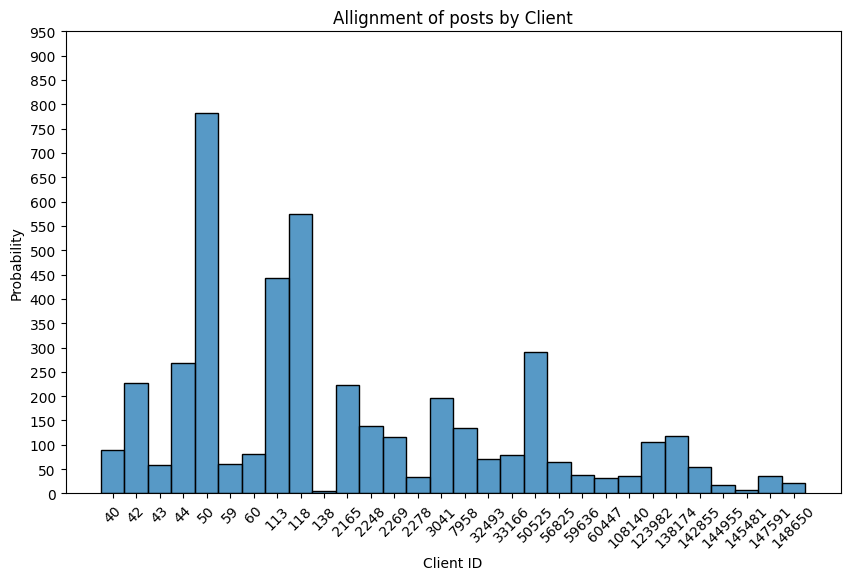


Number of posts per channel:


client_id
138         6
145481      7
144955     18
148650     21
60447      31
2278       34
147591     36
108140     36
59636      38
142855     54
43         58
59         60
56825      65
32493      71
33166      79
60         81
40         90
123982    106
2269      116
138174    118
7958      135
2248      138
3041      196
2165      222
42        228
44        269
50525     291
113       443
118       575
50        782
Name: count, dtype: int64

In [30]:
plt.figure(figsize=(10, 6))  # Optional: adjust the size of the plot
# df_posts_grouped['client_id'].astype(str)
# Replace 'Age' with the actual column name from your DataFrame
g = sns.histplot(df_posts_grouped['client_id'], stat='count')
plt.xticks(rotation = 45)
plt.title('Allignment of posts by Client')
plt.xlabel('Client ID')
plt.ylabel('Probability')
# set the ticks first
g.set_yticks(range(0, 1000, 50))
plt.show()
print("\nNumber of posts per channel:")
# show values sorted ascending
df_posts_grouped['client_id'].value_counts().sort_values()

Luckily, we can balance the dataset by applying class weights, which will boost clients' postings with small number of entities.

To balance it along the project, the manually calculated weights will be applied as well as by LDA, also prediction models, Gradient Boosting (CatBoost) & DecisionTrees

In [31]:
# Count class frequencies
class_frequencies = df_posts_grouped['client_id'].value_counts()

# Calculate class weights
total_samples = len(df_posts_grouped)
num_classes = len(class_frequencies)
class_weights = total_samples / (num_classes * class_frequencies)

# Optionally normalize class weights
normalized_class_weights = class_weights / class_weights.sum()

print("Class Frequencies:")
class_frequencies
print("\nClass Weights:")
class_weights
print("\nNormalized Class Weights:")
normalized_class_weights = normalized_class_weights.reset_index()
normalized_class_weights.columns = ['client_id', 'class_weight']
normalized_class_weights

Class Frequencies:

Class Weights:

Normalized Class Weights:


,client_id,class_weight
0,50,0.001724
1,118,0.002344
2,113,0.003043
3,50525,0.004632
4,44,0.005011
5,42,0.005912
6,2165,0.006072
7,3041,0.006877
8,2248,0.009768
9,7958,0.009985


In [32]:
# Add the found normalized weights to the dataframes (daily & aggregated)
df_posts_weighted = pd.merge(
    df_posts_grouped,
    normalized_class_weights,
    how = 'left',
    on = 'client_id'
)

df_daily_weighted = pd.merge(
    df_valid_posts,
    normalized_class_weights,
    how = 'left',
    on = 'client_id'
)

Let's inspect the distribution of dates in the dataset with daily measurements


Number of measurements per weekday


A:\git_projects\machine-learning-project\venv\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
A:\git_projects\machine-learning-project\venv\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
A:\git_projects\machine-learning-project\venv\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


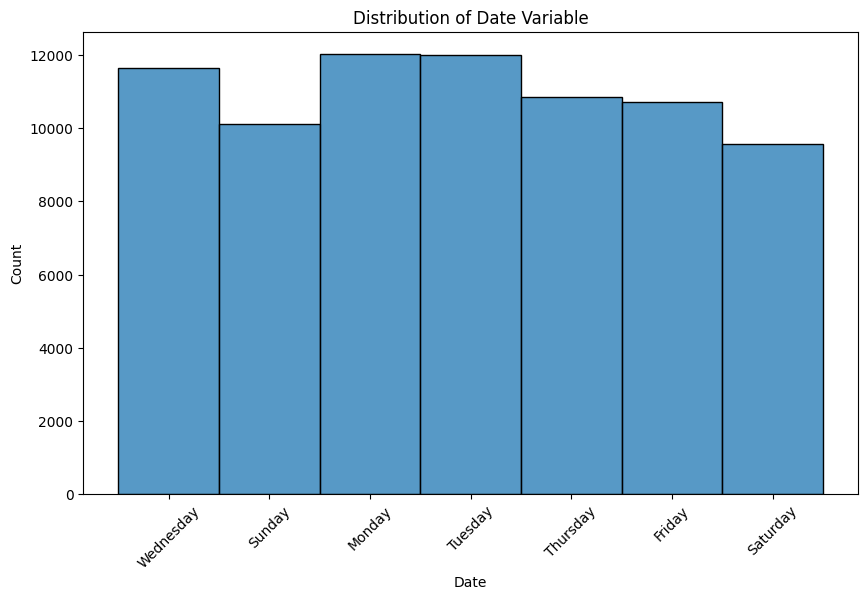

In [33]:
# Group the data by weekday and count occurrences
date_counts = df_daily_weighted['Date'].dt.day_name().value_counts().sort_index()
print("\nNumber of measurements per weekday")
date_counts
# Create a bar plot
plt.figure(figsize=(10, 6))  # Optional: adjust the size of the plot
sns.histplot(df_daily_weighted['Date'].dt.day_name(), stat='count')
# date_counts.astype(str).plot(kind='bar')
plt.xlabel('Date')
plt.ylabel('Count')
plt.title('Distribution of Date Variable')
plt.xticks(rotation=45)  # Optional: Rotate x-axis labels for better readability
plt.show()

We can observe nearly same allocation of daily measurements per weekday, let's see the same allocation of impressions

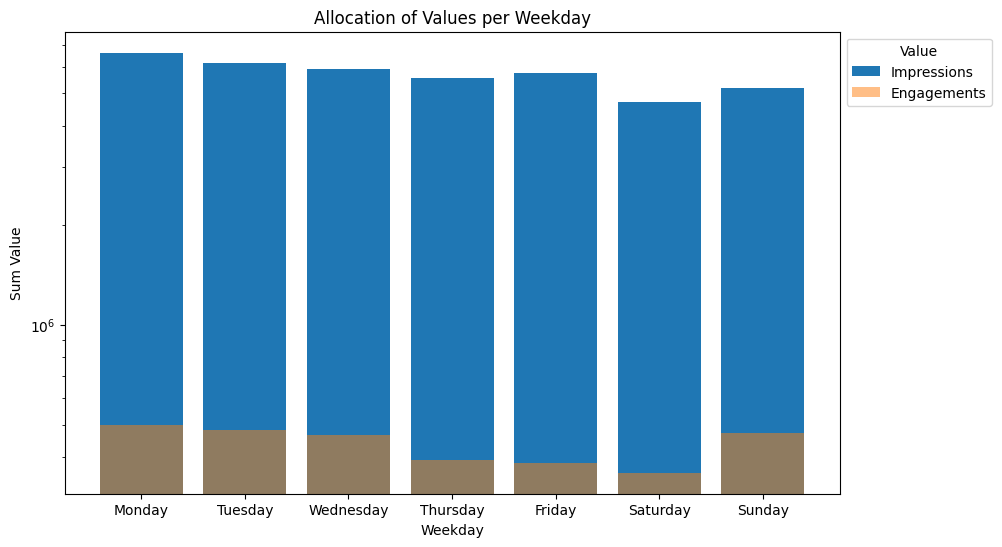

In [34]:
# Group data by weekday and calculate the mean or sum of 'Value1' and 'Value2'
weekday_data = df.groupby(df_daily_weighted['Date'].dt.day_name())[['Impressions', 'Engagements']].sum()  # Or use sum() instead of mean()
cats = [ 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
date_counts = weekday_data.reindex(cats)
date_counts
# Create a bar plot
plt.figure(figsize=(10, 6))  # Optional: adjust the size of the plot
# _ = weekday_data.reindex(cats).plot(kind='bar')
#_ = plt.yscale("log")  
# Plot Impressions with a logarithmic scale on y-axis
plt.bar(date_counts.index, date_counts.Impressions, label='Impressions', log=True)
# Plot Engagements with a logarithmic scale on y-axis
plt.bar(date_counts.index, date_counts.Engagements, label='Engagements', log=True, alpha=0.5)
plt.xlabel('Weekday')
plt.ylabel('Sum Value')  # Change ylabel to 'Sum Value' if using sum()
plt.title('Allocation of Values per Weekday')
plt.xticks(rotation=0)  # Optional: Rotate x-axis labels for better readability
plt.legend(title='Value', bbox_to_anchor=(1, 1))  # Optional: Add a legend
plt.show()

We see nearly equal distribtion of Impressions and Engagements along week days, however we cannot ignore tendention, where most values were collected on the beginning of the week and then falling attention of users, with moderate peak on the sunday.

Let's now deepdive into the daily measurements and inspect how long one post may "live", meaning how much days one post on average collects data. For this, we will group daily measurements for each post, published in a date between 07-01 and 07-31 and look at the cumulative sum of collected data within each day.

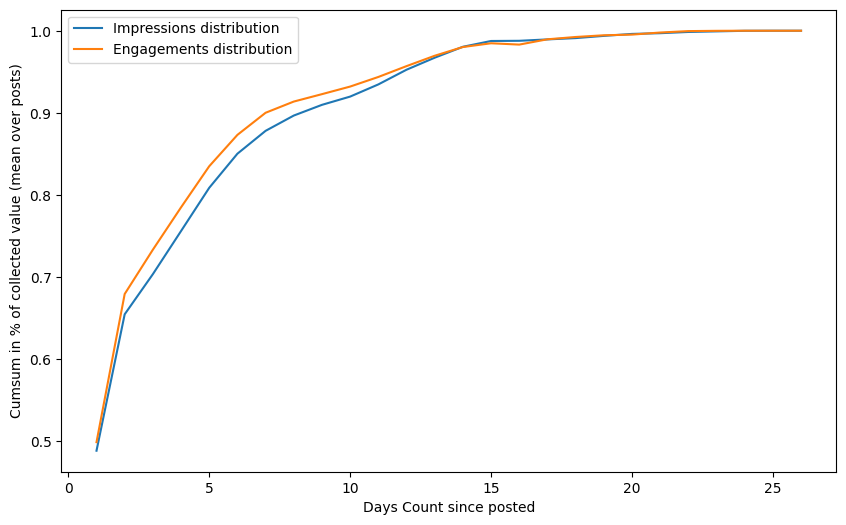

In [35]:
df_daily_distr = df_daily_weighted.loc[pd.to_datetime(df_daily_weighted['Published Date']).dt.month == 7,]
combined_df = df_daily_distr.sort_values('Date').groupby(['client_id', 'post_id', 'Date'])[['Impressions', 'Engagements']].sum()
combined_df['cumsum_imps'] = combined_df.groupby(level=1)['Impressions'].cumsum() / combined_df['Impressions'].groupby(level=1).sum()
combined_df['cumsum_engs'] = combined_df.groupby(level=1)['Engagements'].cumsum() / combined_df['Engagements'].groupby(level=1).sum()
combined_df['days_past'] = combined_df.groupby(level=1).cumcount() + 1 
df_plot = combined_df[['cumsum_imps', 'cumsum_engs', 'days_past']].groupby(['days_past']).mean()
plt.figure(figsize=(10, 6)) 
# plot lines
plt.plot(df_plot.index, df_plot['cumsum_imps'], label = "Impressions distribution")
plt.plot(df_plot.index, df_plot['cumsum_engs'], label = "Engagements distribution")
plt.xlabel('Days Count since posted')
plt.ylabel('Cumsum in % of collected value (mean over posts)')
plt.legend()
plt.show()
#.cumsum().reset_index()
#mrb_cumsum.div(mrb_cumsum.groupby(level=0).last())

We can conclude, that on average every single LI post, published in July collects over 90% of all its data in the first 10 days since the publication date.

Now let's inspect distribution of numeric columns, transform aggregated values, i.e. impressions and engagements. Since it's distribution shows a huge number of outliers, let's transoform the columns with natural logarithm function

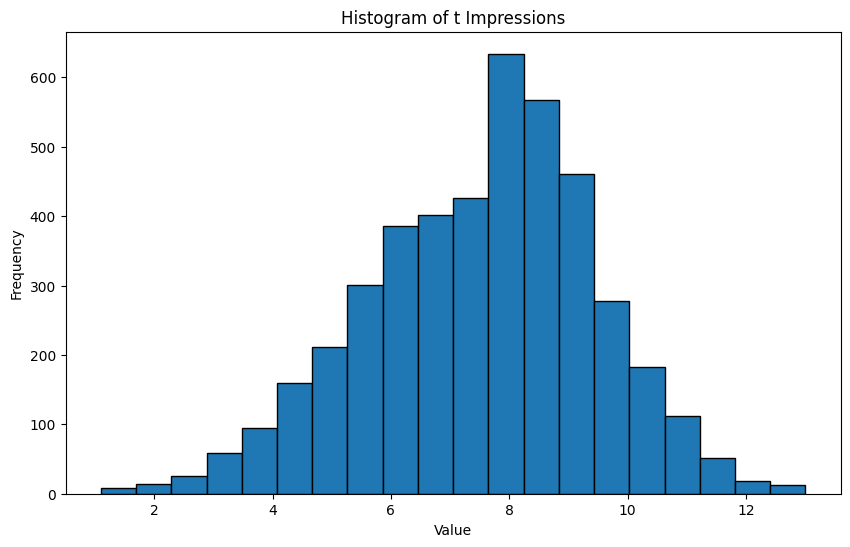

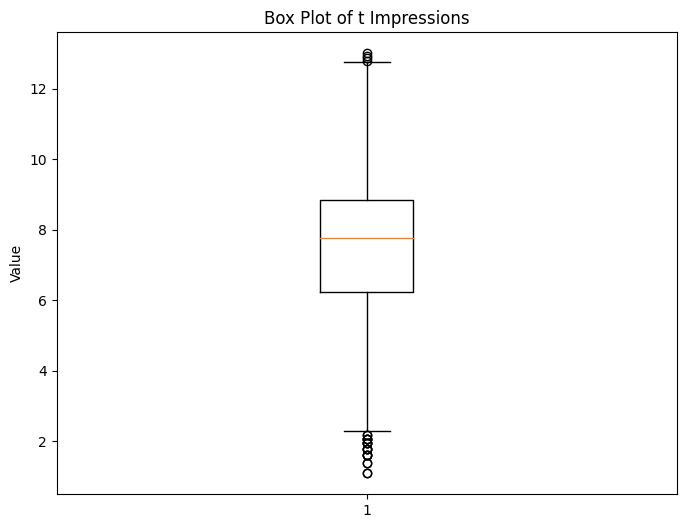

In [36]:
# transformed_data = []
# Impressions
df_posts_weighted['t Impressions'] = np.log(df_posts_weighted['Impressions'])
plt.figure(figsize=(10, 6))
plt.hist(df_posts_weighted['t Impressions'], bins=20, edgecolor='black')
plt.title(f'Histogram of t Impressions')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()
# now boxplot
plt.figure(figsize=(8, 6))
plt.boxplot(df_posts_weighted['t Impressions'])
plt.title(f'Box Plot of t Impressions')
plt.ylabel('Value')
plt.show()
# transformed_data.append((data, lambda_value))

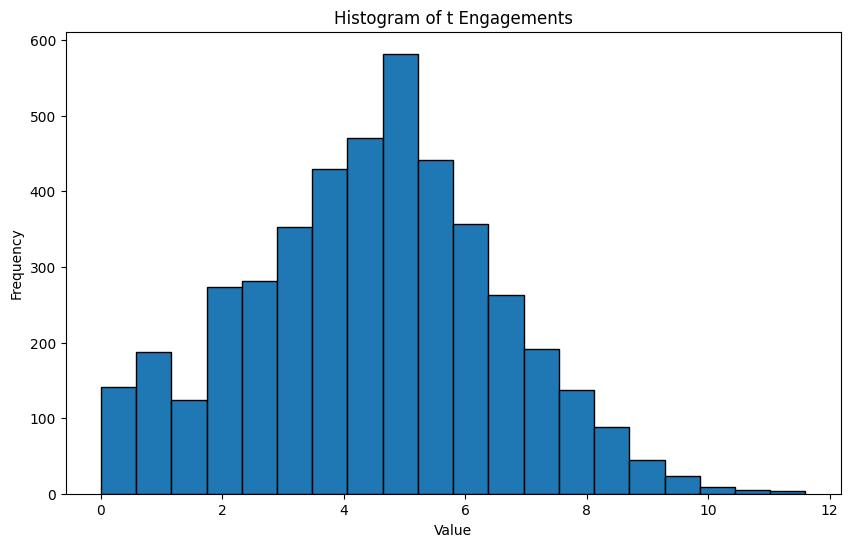

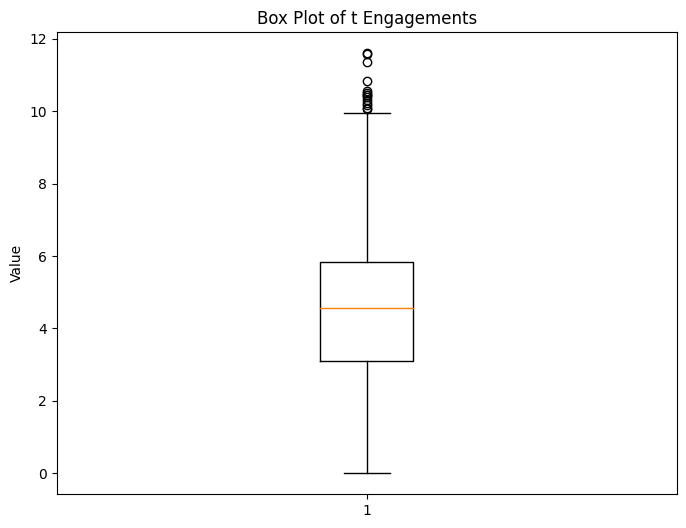

In [37]:
# Engagements
df_posts_weighted['t Engagements'] = np.log(df_posts_weighted['Engagements'])
plt.figure(figsize=(10, 6))
plt.hist(df_posts_weighted['t Engagements'], bins=20, edgecolor='black')
plt.title(f'Histogram of t Engagements')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()
# now boxplot
plt.figure(figsize=(8, 6))
plt.boxplot(df_posts_weighted['t Engagements'])
plt.title(f'Box Plot of t Engagements')
plt.ylabel('Value')
plt.show()

# Outlier Detection

In [38]:
# Assuming 'data' is a pandas DataFrame
clustering = DBSCAN(eps=0.5, min_samples=15).fit(df_posts_weighted[['t Impressions', 't Engagements']])
outliers = clustering.labels_ == -1
outlier_ids_dbscan = df_posts_weighted.loc[outliers, ]['post_id'].unique()
df_posts_weighted.loc[outliers, ]

,client_id,post_id,Message Text,Published Date,Impressions,Likes,Shares,Comments,Engagements,Engagement Rate,class_weight,t Impressions,t Engagements
12,40,urn:li:share:7017050420137074688,"Hello from CES2023! 👋 For us, this year's Cons...",2023-01-06,328582.0,3442.0,90.0,104444.0,107976.0,0.328612,0.014977,12.702542,11.589664
22,40,urn:li:share:7029113195722067968,As emergency aid for the people affected by th...,2023-02-08,359208.0,6012.0,304.0,3888.0,10204.0,0.028407,0.014977,12.791657,9.230535
27,40,urn:li:share:7035236520089251840,Smart Work Abroad – mit Bosch die Welt bereise...,2023-02-25,408080.0,4340.0,61.0,46156.0,50557.0,0.123890,0.014977,12.919219,10.830857
81,40,urn:li:ugcPost:7024021560042647553,"Do you agree with the following statement? 👇 ""...",2023-01-25,350086.0,144.0,3.0,7752.0,7899.0,0.022563,0.014977,12.765934,8.974491
84,40,urn:li:ugcPost:7066382293338075138,"Did you know that bees travel more than 100,00...",2023-05-22,212106.0,972.0,10.0,108131.0,109113.0,0.514427,0.014977,12.264841,11.600139
264,42,urn:li:ugcPost:7039968221482901504,"Dealing with overarching, strategic topics tha...",2023-03-10,117.0,3.0,0.0,47.0,50.0,0.427350,0.005912,4.762174,3.912023
274,42,urn:li:ugcPost:7049780530820612098,Explore »the inseparable relationship between ...,2023-04-07,207.0,33.0,13.0,81.0,127.0,0.613527,0.005912,5.332719,4.844187
332,43,urn:li:ugcPost:7003662151030562816,#SupplyChain diversification will impact our i...,2022-11-30,317.0,0.0,0.0,212.0,212.0,0.668770,0.023241,5.758902,5.356586
355,43,urn:li:ugcPost:7059907240182304768,@[Frank Appel](urn:li:person:q9SEpBm3bx) steps...,2023-05-04,332788.0,5123.0,16.0,33627.0,38766.0,0.116489,0.023241,12.715261,10.565299
661,50,urn:li:share:6996078408828911617,Montaj hattınızda variant ve yüksek adetli üre...,2022-11-09,5.0,1.0,0.0,0.0,1.0,0.200000,0.001724,1.609438,0.000000


In [39]:
# remove outlier posts from both datasets
df_posts_weighted_no_outliers = df_posts_weighted.loc[~outliers, ]
df_daily_weighted_no_outliers = df_daily_weighted.loc[~df_daily_weighted['post_id'].isin(outlier_ids_dbscan),]

In [40]:
df_posts_weighted_no_outliers.describe()

,Impressions,Likes,Shares,Comments,Engagements,Engagement Rate,class_weight,t Impressions,t Engagements
count,4356.000000,4356.000000,4356.000000,4356.000000,4356.000000,4356.000000,4356.000000,4356.000000,4356.000000
mean,7900.899908,105.594353,4.809917,430.507805,540.912075,0.066246,0.009207,7.539143,4.459280
std,18063.826747,209.127608,8.651521,1525.004682,1640.998592,0.072283,0.014959,1.873180,2.034460
min,6.000000,0.000000,0.000000,0.000000,1.000000,0.003311,0.001724,1.791759,0.000000
25%,514.750000,10.000000,0.000000,8.000000,22.000000,0.026282,0.002344,6.243681,3.091042
50%,2371.500000,41.000000,2.000000,40.000000,97.000000,0.041892,0.005011,7.771278,4.574711
75%,6932.500000,113.000000,6.000000,188.250000,337.000000,0.077033,0.011423,8.843976,5.820083
max,267662.000000,2653.000000,121.000000,29360.000000,30026.000000,0.940660,0.224662,12.497480,10.309819


In [41]:
# save cleaned datasets for further processing
df_posts_weighted_no_outliers.to_csv(os.path.join(os.getenv('SAVE_INTERIM_FILES_PATH'), 'agg_posts_weighted.csv'), index=False, encoding='UTF-8')
df_daily_weighted_no_outliers.to_csv(os.path.join(os.getenv('SAVE_INTERIM_FILES_PATH'), 'daily_measures_weighted.csv'), index=False, encoding='UTF-8')

# Insights and Conclusion

During the data cleaning we found and tried to explain following anomalies:
- Handling invalid post ids collected from the LinkedIn API, generating missing ids
- Handling posts with missing message text
- Data deduplication
- Normalizing Engagement Rate of aggregated posts

Then on the cleaned dataset descriptive columns were further analyzed. After applying descriptive metrics on the numeric column, we found out that daily measurements as well as grouped posts are unequally distrubited with a huge gap between max values and their 75% quantiles.

During data exploration, we had to conclude that we deal with an imbalanced dataset, since some companies may flood with posts, while other accounts posting rather occasionally. For balancing the dataset, we calculated class weights, which will be further applied whils computing LDA and predictive modelling.

Also, we found out how daily measurements are distributed along the weekdays (count of measurements) and those distributions explained by the sum of aggregated posts' metrics (Impressions and Engagements). We observed exceeding peaks on the beginning of the week and falling number of user activity during the middle of the week with the slight grow on Sunday. This information may help to identify best weekday for content posting.

Added to the strategy of choosing the best week day, when a post may be published, we observed, how long a post usually "lives" on LinkedIn, so we found that on average a post achieves over 90% of impressions or engagements during the first 10 days after its publication, after we saw an exponent fall till 100% on the 25th day.

Since we work with aggregated columns (Impressions and Engagements), we will scale it down via natural logarithm in order to reduce the gap between observations.

On the normalized values, we furhter analyzed, how our main metrics are distributed. So, we concluded, that normalized impressions are leftskewed and engagements show, on the other hand, rightskewed distribution.

Furhter we applied DBSCAN method in order to filter out outliers from the dataset based on the (new) normalized Engagements and Impressions. This is done in order to reduce possible impact of outliers by training sensitive predictive models in the future.